# Data 620: Final Project
### Aaron Grzasko
### 12/18/2018

## Introduction

*The Sopranos* is a critically acclaimed crime TV series that originally aired on HBO from 1999 to 2007.
The series follows Tony Soprano, a New Jersey-based mafia boss who struggles with depression.  Throughout the drama's six seasons, Tony strives to maintain a relatively normal, suburban family life while also leading a criminal enterprise and engaging in frequent salacious and violent behavior with his mafia associates.

The show features a sprawling storyline and a large cast of characters--characteristics that are well-suited for social network analysis.

Furthermore, many of the characters in *The Sopranos* exhibit conflicting and shifting loyalties throughout the series' timeline.  Mafia members within the Soprano criminal organiztion are often at odds with other.  Some characters serve as informants to police as a last ploy to avoid lengthy prison sentences.  There is even an episode in the series where Tony's own mother appears request a "hit" on her son.  Using sentiment analysis, we hope to capture some of the shifting dyamics between cast members.     


## Data Overview

Ideally, we would have liked to perform an analysis using all 86 episodes from six seasons of *The Sopranos*.  
Dialogue for all episodes is freely available online--see [springfieldspringfield.co.uk](https://www.springfieldspringfield.co.uk/episode_scripts.php?tv-show=the-sopranos).  Unfortunately, the springfield website does not specify which characters are speaking each line of displayed text.  We would need to infer the speaker of each line of dialogue, using a rules-based procedure or through manual assignment.

Due to the limitations of the available online data, we decided to purchase the ebook, *The Sopranos: Selected Scripts From Three Seasons* by David Chase.  The character dialogue from the book can be easily scraped using two popular python libaries: *epub* and *BeautifulSoup*.  The downside to this data source is scripts are provided for only five Sopranos episodes.  On the other hand, the book clearly attributes each line of dialogue to a specific character, which is imperative for performing a
meaningful analysis.  
  
Here is an overview of the five episodes from the book:  
* "The Sopranos" - season one, episode one.
 - Tony visits a therapist after suffering a fainting episode.
 - Uncle Junior plans a hit inside Artie Bucco's restauarant.
 - Tony orders Silvio to set fire to the restaurant to prevent the hit.
* "College" - season one, episode five.  
 - Tony takes his daughter Meadow on a road trip to visit prospective colleges.
 - While on the road trip, Tony hunts down a former mafia member turned FBI informant.
* "The Happy Wanderer" - season two, episode six.
 - Tony team overseas a high-stakes poker game.
 - Tony's college friend David, a compulsive gambler, joins the game.  
 - Unable to cover his losses, David gives his son's SUV to Tony as parital payment.  
 
* "The Knight in White Satin Armor" - season two, episode twelve. 
 - Tony's mistress, Irinia, attempts to commit suicide after he attempts to break up with her.
 - Big Pussy wears a wire and provides mafia goings-on with the FBI.
 - Janice, Tony's sister, kills her fiancne--mafia captain Richie--after a brief alteraction.
* "Pine Barrens" - season three, episode eleven.
  - Tony's associates, Paulie and Christopher, have an altercation with Russian mobster, Valery.
  - They transport Valery to the Pine Barrens to kill and bury him.
  - Valery ends up escaping.  Paulie and Christopher end up lost in the wood. 

## Read in Data

Before we perform any analysis, we will import all relevant python libaries:

In [162]:
# import relevant libraries
import epub
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import math
import seaborn as sns
import warnings
from textblob import TextBlob

# declare default behavior within notebook
warnings.filterwarnings('ignore')
%matplotlib inline

Now let's read in the data.

In [163]:
# establish connection to ebook
book  =  epub.open_epub('Sopranos.epub')

# specify episodes to read-in
ep1 = book.read_item(book.get_item_by_href('Sopranos_chap_1.html')) 
ep2 = book.read_item(book.get_item_by_href('Sopranos_chap_2.html'))
ep3 = book.read_item(book.get_item_by_href('Sopranos_chap_3.html'))
ep4 = book.read_item(book.get_item_by_href('Sopranos_chap_4.html'))
ep5 = book.read_item(book.get_item_by_href('Sopranos_chap_5.html'))

## Data Scrubbing

The data are not yet in a format amenable to perfoming network or sentiment analysis.  
The episode dialogue are in the form of raw HTML.  Using regex and BeautifulSoup packages, we wrangle the data into cleaner form and store in a pandas DataFrame.  

Below are multiple helper functions used to scrub the raw HTML dialogue.

In [164]:
def scrub_script(episode):
    """Initial scrubbing script:
            Reads scene number/description, character, and relevant dialogue
    """
    # extract relevant text relating to scene number, character, and corresponding dialogue.
    script = BeautifulSoup(episode, 'lxml')
    script = script.find_all("p", ["p1","dt1","np2"])
    script = [s.text for s in script]
    
    # remove extraneous text on lines referencing the character who is speaking
    script = [s.replace('(V.O.)','') for s in script]
    script = [s.replace("(CONT’D)","") for s in script]
    script = [s.replace("\n","") for s in script]
    script = [s.replace("(0.S.)","") for s in script]
    script = [s.replace("(O.S.)","") for s in script]
    script = [s.replace("(O.S)","") for s in script]
            
    return(script)   


def find_scene(script):
    """
    Determine scene number:
        For each line of text, determine the applicable scene number 
    """
    
    # assign scene number to each line in text
    scene = list(map(lambda x: "".join(re.findall('^\\d+|CUT TO:',x)),script))
    for i in range(len(scene)):
        scene[i] = scene[i] if scene[i] != '' else scene[i-1]
    
    # regex isn't perfect.  Manually fix mistakenly assigned scene numbers. 
    scene = [s.replace("327","7") for s in scene]
    
    return scene


def find_dialogue(script):
    """
    Extract dialogue from text, if applicable
    """
    dialogue = []
    
    # pull text dialogue if line meets specified criteria
    for ln in script:
        if re.search("[a-z]+", ln) and not re.search('^\\d+',ln):
            dialogue.append(ln.strip())
    
    # otherwise assign "Not Dialogue" to line
        else:
            dialogue.append("Not Dialogue")
    return(dialogue)


def find_characters(script):
    """
    Pull character name from line, if applicable
    """
    characters = []
    # pull text specifying character, if applicable
    for ln in script:
            try:
                if re.search("^[A-Z\\. ]{2,}[A-Z\\. ]+",ln) and not re.search("[a-z]|CUT TO|!",ln):
                    name = "".join(re.findall("^[A-Z\\. ]{2,}[A-Z\\. ]+",ln))
                    characters.append(name.strip())
                else:
                    characters.append(characters[-1])
    # otherwise, assign "Not Character"
            except:
                    characters.append("Not Character")
    
    # fix character names that are either misspelled or referenced using multiple names
    characters = [s.replace("BIG PUSSY","PUSSY") for s in characters]
    characters = [s.replace("PAULIE WALNUTS","PAULIE") for s in characters]
    characters = [s.replace("MELEI","MELFI") for s in characters]
    characters = [s.replace("DAVTD","DAVID") for s in characters]
    
    return(characters)


def line_type(char_list, dialogue_list):
    """
    Assign each line of file to one of three types:
            "character", "dialogue", or "scene"
    """
    line_type = []
    for i in range(len(char_list)):
        if dialogue_list[i] == "Not Dialogue":
            if char_list[i] == "Not Character":
                line_type.append('scene')
            else:
                line_type.append("character")
        else:
            line_type.append("dialogue")
    return(line_type)
            

def episode_df(episode, ep_no):
    """
    Using other helper functions, consolidate
    raw HTML data to pandas dataframe
    """
   
    script = scrub_script(episode)
    scene = find_scene(script)
    char = find_characters(script)
    dial = find_dialogue(script)
    lt = line_type(char,dial)
    ep = [ep_no] * len(char)
    
    d = {'episode': ep,'line_type': lt, 'scene':scene, 'character': char,  'dialogue':dial}
    df = pd.concat([pd.Series(v, name=k) for k, v in d.items()], axis=1)
    df = df[(df.line_type == 'dialogue') & (df.character != "Not Character")]
    return(df)

Using the helper functions defined above, we save the episode script data to a pandas DataFrame. 

In [165]:
# save data for each episode in separate dataframe
df1 = episode_df(ep1, 1)
df2 = episode_df(ep2, 2)
df3 = episode_df(ep3, 3)
df4 = episode_df(ep4, 4)
df5 = episode_df(ep5, 5)

# concatenate all data together
frames = [df1, df2, df3, df4, df5]
df_all = pd.concat(frames)

## View Data

Here are the first ten lines from our newly created DataFrame:

In [166]:
# view first 10 lines from dataframe
df_all.head(10)

,episode,line_type,scene,character,dialogue
2,1,dialogue,1,MELFI,Mr. Soprano?
5,1,dialogue,2,MELFI,Have a seat.
7,1,dialogue,2,MELFI,"My understanding from your family physician, D..."
9,1,dialogue,2,TONY,They said it was a panic attack — because all ...
11,1,dialogue,2,MELFI,You don’t agree you had a panic attack?
13,1,dialogue,2,MELFI,How are you feeling now?
15,1,dialogue,2,TONY,Now? Fine. I’m back at work.
17,1,dialogue,2,MELFI,What line of work are you in?
19,1,dialogue,2,TONY,Waste management consultant.
21,1,dialogue,2,MELFI,Any thoughts at all on why you blacked out?


Below is a list of the unique characters with speaking parts in the five Sopranos episodes.  There are almost 100 characters in total.

In [167]:
characters_all = list(set(df_all.character))

print("There are {} unique characters.".format(len(characters_all)))
print("\nList of characters:")
print(sorted(characters_all))

There are 93 unique characters.

List of characters:
['ADRIANA', 'ALBERT', 'ANNOUNCER VOICE', 'ANTHONY JR.', 'ARTHUR', 'ARTIE', 'ATTENDANT', 'BACALA', 'BARBARA', 'BARTENDER', 'BEPPY', 'BOTH PARENTS', 'BOWDOIN STUDENT', 'CAITLIN', 'CARMELA', 'CHARMAINE', 'CHRISTOPHER', 'COMPUTER VOICE', 'COP', 'CUBITOSO', 'DAUGHTER', 'DAVID', 'DEALER', 'DEAN', 'DICK BARONE', 'DIRECTOR', 'DR. FREID', 'ERIC', 'FATHER PHIL', 'FISH MAN', 'FRANK SINATRA JR.', 'FURIO', 'GABRIELLA', 'GLORIA', 'HERMAN', 'HILLEL', 'HOOKER', 'HOSTESS', 'HUGH', 'HUNTER', 'ILANA', 'IRINA', 'JACKIE JR.', 'JANICE', 'JOHNNY SACK', 'JUNIOR', 'KIDS', 'KOLAR', 'LE DOYENNNE', 'LILLIANA', 'LIPARI', 'LIVIA', 'LUCINDA', 'MAHAFFEY', 'MAHENDRA', 'MALE VOICE', 'MAN', 'MARY', 'MATT', 'MEADOW', 'MELFI', 'MELVOIN', 'MRS. GAETANO', 'MRS. SCATINO', 'NILS', 'NURSE', 'OWNER', 'PARVATI', 'PAULIE', 'PETERS', 'PRIEST', 'PUSSY', 'REP', 'RICHIE', 'RICK', 'RITA', 'ROSALIE', 'SEAN', 'SILVIO', 'SLAVA', 'STUDENT WORKER', 'SUNSHINE', 'SVETLANA', 'TONY', 'TONY A

In [168]:
sorted(characters_all)

['ADRIANA',
 'ALBERT',
 'ANNOUNCER VOICE',
 'ANTHONY JR.',
 'ARTHUR',
 'ARTIE',
 'ATTENDANT',
 'BACALA',
 'BARBARA',
 'BARTENDER',
 'BEPPY',
 'BOTH PARENTS',
 'BOWDOIN STUDENT',
 'CAITLIN',
 'CARMELA',
 'CHARMAINE',
 'CHRISTOPHER',
 'COMPUTER VOICE',
 'COP',
 'CUBITOSO',
 'DAUGHTER',
 'DAVID',
 'DEALER',
 'DEAN',
 'DICK BARONE',
 'DIRECTOR',
 'DR. FREID',
 'ERIC',
 'FATHER PHIL',
 'FISH MAN',
 'FRANK SINATRA JR.',
 'FURIO',
 'GABRIELLA',
 'GLORIA',
 'HERMAN',
 'HILLEL',
 'HOOKER',
 'HOSTESS',
 'HUGH',
 'HUNTER',
 'ILANA',
 'IRINA',
 'JACKIE JR.',
 'JANICE',
 'JOHNNY SACK',
 'JUNIOR',
 'KIDS',
 'KOLAR',
 'LE DOYENNNE',
 'LILLIANA',
 'LIPARI',
 'LIVIA',
 'LUCINDA',
 'MAHAFFEY',
 'MAHENDRA',
 'MALE VOICE',
 'MAN',
 'MARY',
 'MATT',
 'MEADOW',
 'MELFI',
 'MELVOIN',
 'MRS. GAETANO',
 'MRS. SCATINO',
 'NILS',
 'NURSE',
 'OWNER',
 'PARVATI',
 'PAULIE',
 'PETERS',
 'PRIEST',
 'PUSSY',
 'REP',
 'RICHIE',
 'RICK',
 'RITA',
 'ROSALIE',
 'SEAN',
 'SILVIO',
 'SLAVA',
 'STUDENT WORKER',
 'SUNSHINE',

## Network Analysis

We define a pair of characters to have interacted (i.e. are connected) if both individuals have speaking parts within the same episode scene.  Characters that speak in multiple scenes together will have higher edge weights.  
  
Before we build our network graph, we build a couple helper functions to determine the number of interactions between pairs of characters.

In [ ]:
def sort_tuple(x):
    """
    Helper function to sort tuple ordering in alphabetical order.
        For instance, '(Tony, Carmela)' and '(Carmela, Tony)' will both
        sort to '(Carmela, Tony)'.
    
    """
    mylist = []
    for e in x:
        mylist.append(tuple(sorted([e[0],e[1]])))
    return(set(mylist))
                   
def interactions(df):
    """
    Determine number of interactions between pairs
        of characters.
    """
    df_unique = df.groupby(['episode','scene','character']).size().reset_index().rename(columns={0:'count'})
    #print(df_unique)
    interactions = dict()
    
    for ep in df_unique.episode.unique():
        for scn in df_unique.scene.unique():
            temp_df = df_unique[(df_unique.scene == scn) & (df_unique.episode == ep)]
            temp_inter = sort_tuple(list(itertools.combinations(set(temp_df.character),2)))
            for pair in temp_inter:
                if pair in interactions:
                    interactions[pair] += 1
                else:
                    interactions[pair] = 1
    return(interactions)
                  


**Full Sopranos Graph**

Now we are ready to produce the graph.

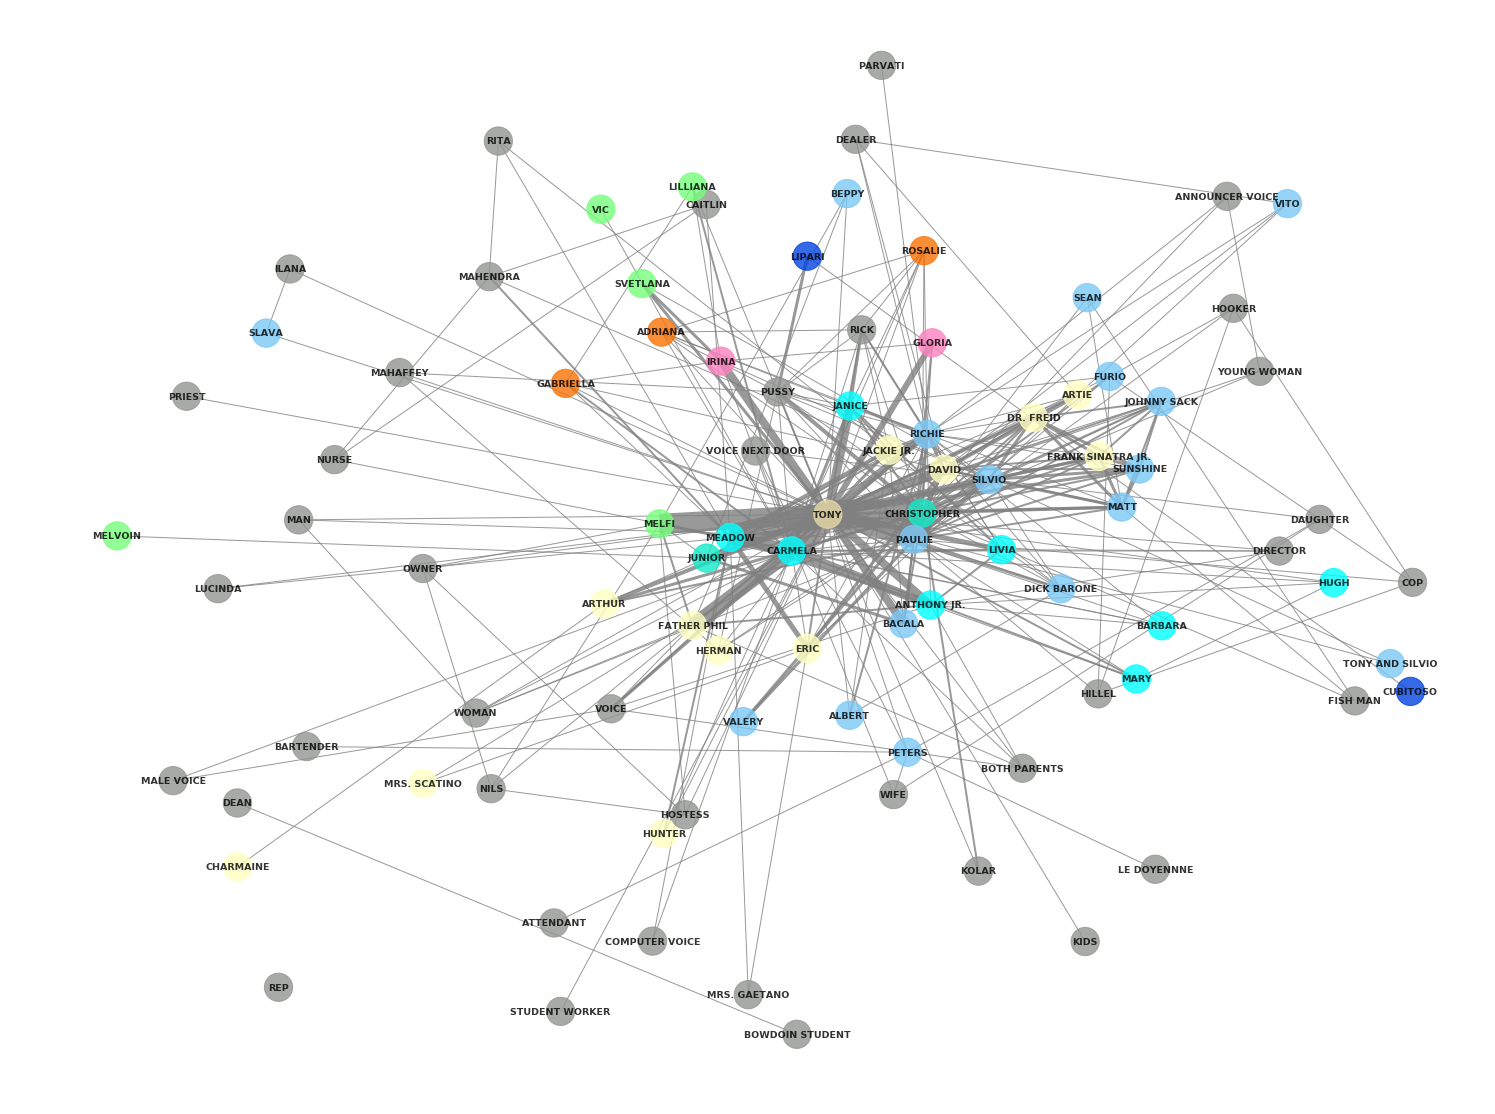

In [218]:
#instantiate network graph
G=nx.Graph()

# define interactions between characters
interactions_all = interactions(df_all)

# create graph edges
edge_tuples = list()
for k,v in interactions_all.items():
    edge_tuples.append((k[0],k[1],v))

# add nodes to graph
G.add_nodes_from(characters_all)

# assign character type
char_typ = {'ADRIANA':'Mafia Significant Other', 'ALBERT':'Mafia', 'ANNOUNCER VOICE':'Other', 'ANTHONY JR.':'Immediate Family',
 'ARTHUR':'Family Friend', 'ARTIE':'Family Friend', 'ATTENDANT':'Other', 'BACALA':'Mafia', 'BARBARA':'Immediate Family',
 'BARTENDER':'Other', 'BEPPY':'Mafia', 'BOTH PARENTS':'Other', 'BOWDOIN STUDENT':'Other', 'CAITLIN':'Other',
 'CARMELA':'Immediate Family', 'CHARMAINE':'Family Friend', 'CHRISTOPHER':'Mafia/Extended Family',
 'COMPUTER VOICE':'Other', 'COP':'Other', 'CUBITOSO':'FBI', 'DAUGHTER':'Other', 'DAVID':'Family Friend',
 'DEALER':'Other', 'DEAN':'Other', 'DICK BARONE':'Mafia', 'DIRECTOR':'Other', 'DR. FREID':'Family Friend',
 'ERIC':'Family Friend', 'FATHER PHIL':'Family Friend', 'FISH MAN':'Other', 'FRANK SINATRA JR.':'Family Friend',
 'FURIO':'Mafia', 'GABRIELLA':'Mafia Significant Other', 'GLORIA':'Mistress', 'HERMAN':'Family Friend',
 'HILLEL':'Other', 'HOOKER':'Other', 'HOSTESS':'Other', 'HUGH':'Immediate Family', 'HUNTER':'Family Friend',
 'ILANA':'Other', 'IRINA':'Mistress', 'JACKIE JR.':'Family Friend', 'JANICE':'Immediate Family',
 'JOHNNY SACK':'Mafia', 'JUNIOR':'Mafia/Extended Family', 'KIDS':'Other', 'KOLAR':'Other',
 'LE DOYENNNE':'Other', 'LILLIANA':'Service Provider', 'LIPARI':'FBI', 'LIVIA':'Immediate Family',
 'LUCINDA':'Other', 'MAHAFFEY':'Other', 'MAHENDRA':'Other', 'MALE VOICE':'Other', 'MAN':'Other',
 'MARY':'Immediate Family', 'MATT':'Mafia', 'MEADOW':'Immediate Family', 'MELFI':'Service Provider',
 'MELVOIN':'Service Provider', 'MRS. GAETANO':'Other', 'MRS. SCATINO':'Family Friend',
 'NILS':'Other', 'NURSE':'Other', 'OWNER':'Other', 'PARVATI':'Other', 'PAULIE':'Mafia',
 'PETERS':'Mafia', 'PRIEST':'Other', 'PUSSY':'Other', 'REP':'Other', 'RICHIE':'Mafia',
 'RICK':'Other', 'RITA':'Other', 'ROSALIE':'Mafia Significant Other', 'SEAN':'Mafia',
 'SILVIO':'Mafia', 'SLAVA':'Mafia', 'STUDENT WORKER':'Other', 'SUNSHINE':'Mafia',
 'SVETLANA':'Service Provider', 'TONY':'Tony', 'TONY AND SILVIO':'Mafia', 'VALERY':'Mafia',
 'VIC':'Service Provider', 'VITO':'Mafia', 'VOICE':'Other', 'VOICE NEXT DOOR':'Other',
 'WIFE':'Other', 'WOMAN':'Other', 'YOUNG WOMAN':'Other'}

nx.set_node_attributes(G, char_typ, name='char_typ')

# add weighted edges
G.add_weighted_edges_from(edge_tuples)

# store edge weights in list
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]


# assign colors
node_col = []
for g in G.nodes(data=True):
    #print(g[1]['char_typ'])
    if "Tony" in g[1]['char_typ']:
        node_col.append('xkcd:beige')
    elif "Mafia Significant Other" in g[1]['char_typ']:
        node_col.append('xkcd:orange')
    elif "Mafia/Extended Family" in g[1]['char_typ']:
        node_col.append('xkcd:aqua')
    elif "Mafia" in g[1]['char_typ']:
        node_col.append('xkcd:lightblue')
    elif "Immediate Family" in g[1]['char_typ']:
        node_col.append('xkcd:cyan')
    elif "FBI" in g[1]['char_typ']:
        node_col.append('xkcd:blue')
    elif "Mistress" in g[1]['char_typ']:
        node_col.append('xkcd:pink')
    elif "Service Provider" in g[1]['char_typ']:
        node_col.append('xkcd:lightgreen')
    elif "Family Friend" in g[1]['char_typ']:
        node_col.append('xkcd:cream')
    else:
        node_col.append('xkcd:gray')

# plot graph
plt.figure(figsize=(20,15)) 
nx.draw(G, with_labels=True, font_size = 9.5, node_size = 800,\
        font_weight = 'bold', alpha = 0.8, node_color=node_col, edge_color='gray', 
        pos=nx.spring_layout(G,k=0.40, iterations=20), width = weights)

We colored the nodes based on the character attributes that were assigned manually--and in some cases, subjectively.  
The color breakdown is as follows:
* Beige - Tony
* Light Blue - Mafia
* Cyan - Immediate Family
* Aqua - Mafia/Extended Family
* Orange - Mafia Significant Other
* FBI - Blue
* Mistress - Pink
* Service Provider - Light Green
* Family Friend - Cream
* Other - Grey


Here are our initial observations from the graph:  
* Tony appears in the center of the graph, and has the greatest number of interactions.  This makes sense, as Tony is the lead character in the show.
* Tony's primary interactions involve his immediate family, higher level mafia personnel (i.e. captains), and close family friends.
* Tony also interacts frequently with his psychiatrist, Dr. Melfi.
* The FBI do appear to have a significant influence in the social network.


**Basic Graph Metrics and Charts**

Here are some high-level stats for our network:

In [28]:
# size of network
print("size of network: {}".format(len(G)))

# graph diameter
subgraph = list(nx.connected_component_subgraphs(G))[0]
print("\nlargest subgraph diameter: {}".format(nx.diameter(subgraph)))

# maximum degree
print("\nmaximum weighted degree: {}".format(max(G.degree(weight='weight'), key=lambda x: x[1])))

# minimum degree
print("minimum weighted degree: {}".format(min(G.degree(weight='weight'), key=lambda x: x[1])))

# top 10 nodes in terms of degree
print("\nTop 10 Weighted Degrees:")

# top 10 
print(sorted([(x,y) for x,y in G.degree(weight='weight')], key=lambda z: z[1], reverse=True)[0:10])

print("\nBottom 10 Weighted Degrees:")
print(sorted([(x,y) for x,y in G.degree(weight='weight')], key=lambda z: z[1])[0:10])



size of network: 93

largest subgraph diameter: 5

maximum weighted degree: ('TONY', 262)
minimum weighted degree: ('REP', 0)

Top 10 Weighted Degrees:
[('TONY', 262), ('CHRISTOPHER', 108), ('CARMELA', 101), ('PAULIE', 79), ('MEADOW', 70), ('RICHIE', 46), ('SILVIO', 41), ('DAVID', 40), ('ANTHONY JR.', 31), ('MELFI', 30)]

Bottom 10 Weighted Degrees:
[('REP', 0), ('ATTENDANT', 1), ('KIDS', 1), ('LE DOYENNNE', 1), ('CHARMAINE', 1), ('STUDENT WORKER', 1), ('BARTENDER', 1), ('BOWDOIN STUDENT', 1), ('CUBITOSO', 1), ('PRIEST', 1)]


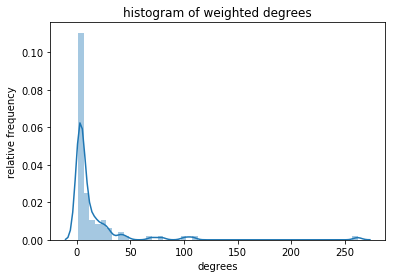

In [219]:
deg_vals = np.array([v for k,v in subgraph.degree(weight='weight')])
ax = sns.distplot(deg_vals)
plt.title('histogram of weighted degrees')
plt.xlabel('degrees')
plt.ylabel('relative frequency')
plt.show()

In [458]:
for f, to, edata in G.edges(data=True):
    print((f,to,edata))

('VITO', 'RICHIE', {'weight': 1})
('VITO', 'DEALER', {'weight': 1})
('VITO', 'DAVID', {'weight': 1})
('VITO', 'ARTIE', {'weight': 1})
('ILANA', 'SLAVA', {'weight': 1})
('ILANA', 'TONY', {'weight': 1})
('CAITLIN', 'NURSE', {'weight': 1})
('CAITLIN', 'MEADOW', {'weight': 1})
('CAITLIN', 'MAHENDRA', {'weight': 1})
('GABRIELLA', 'MEADOW', {'weight': 1})
('GABRIELLA', 'SILVIO', {'weight': 1})
('GABRIELLA', 'CARMELA', {'weight': 2})
('GABRIELLA', 'TONY', {'weight': 1})
('GABRIELLA', 'IRINA', {'weight': 1})
('GABRIELLA', 'LILLIANA', {'weight': 1})
('DAUGHTER', 'PETERS', {'weight': 1})
('DAUGHTER', 'VOICE NEXT DOOR', {'weight': 1})
('DAUGHTER', 'WIFE', {'weight': 1})
('ANNOUNCER VOICE', 'CHRISTOPHER', {'weight': 1})
('ANNOUNCER VOICE', 'TONY', {'weight': 1})
('ANNOUNCER VOICE', 'YOUNG WOMAN', {'weight': 1})
('CARMELA', 'MEADOW', {'weight': 13})
('CARMELA', 'TONY', {'weight': 27})
('CARMELA', 'FATHER PHIL', {'weight': 14})
('CARMELA', 'VOICE', {'weight': 3})
('CARMELA', 'BOTH PARENTS', {'weight

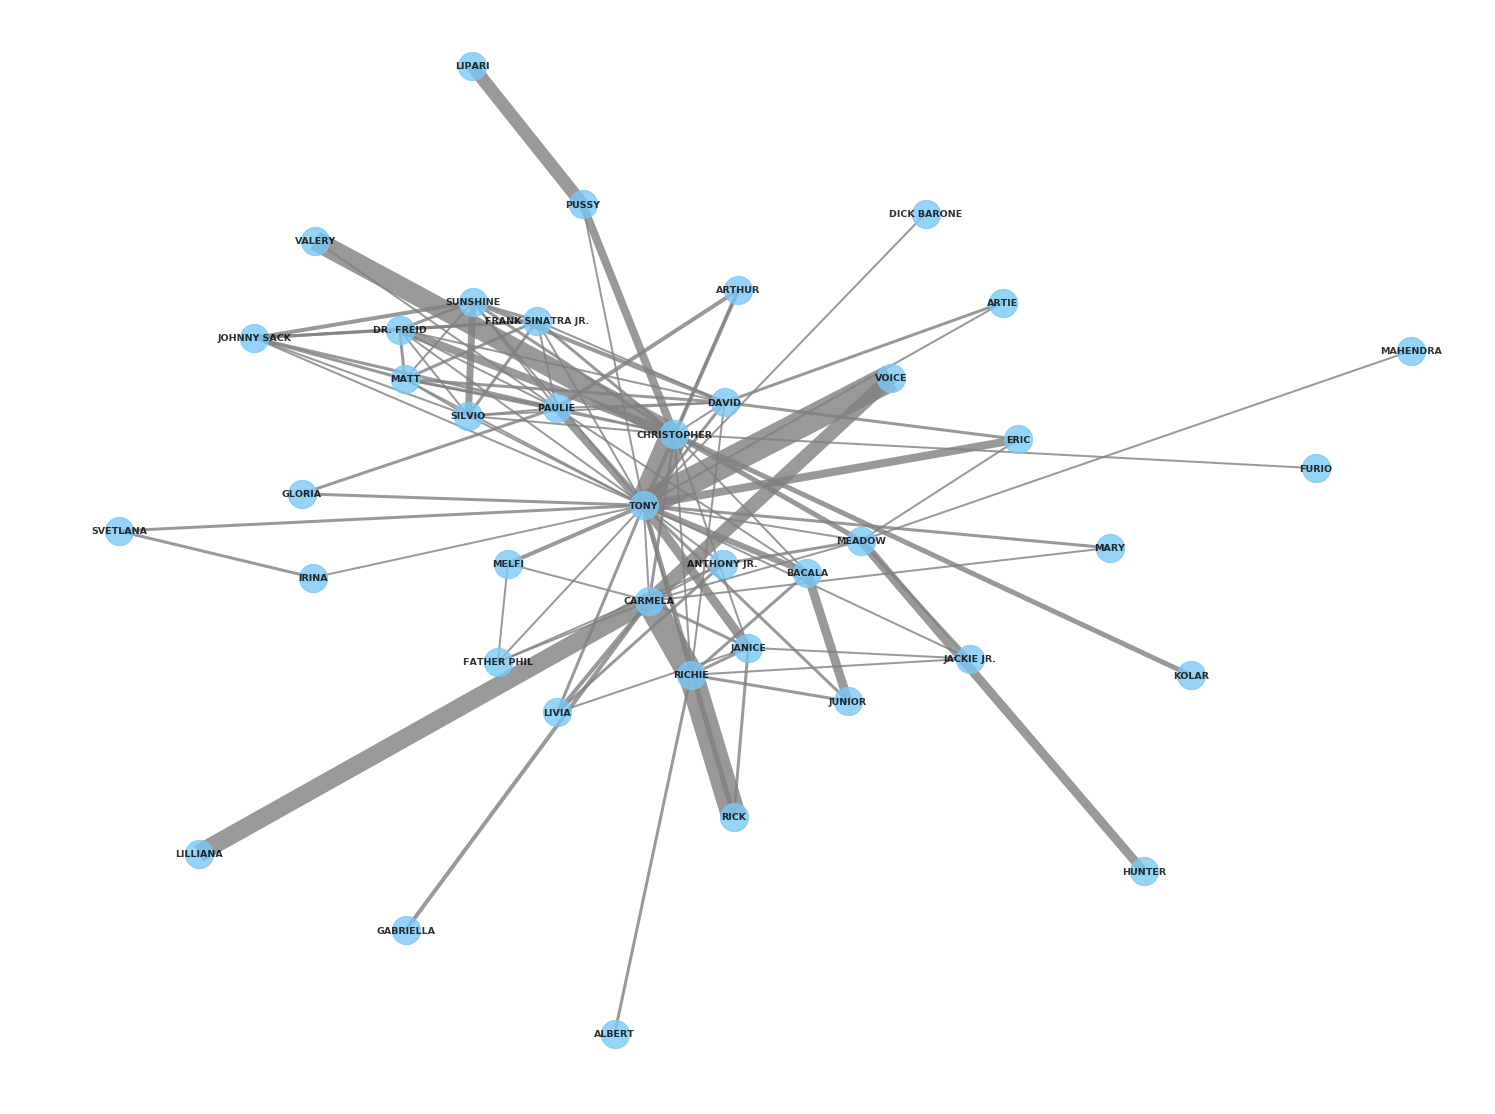

In [12]:
def trim_edges(node_source, edge_source, weight = 1):
    H = nx.Graph()
    H.add_nodes_from(node_source)
    #edges = list()
    edges = [(k1,k2,v) for (k1,k2,v) in edge_source if v > weight]
    H.add_weighted_edges_from(edges)
    return(H)
   


G2 = trim_edges(characters_all, edge_tuples, weight = 1)
G2sub = list(nx.connected_component_subgraphs(G2))[0]

#nx.draw(G2)
edges_sub = G2.edges()
weights_sub = [G2[u][v]['weight'] for u,v in edges_sub]
plt.figure(figsize=(20,15)) 
nx.draw(G2sub, with_labels=True, font_size = 9.5, node_size = 800,\
        font_weight = 'bold', alpha = 0.8, node_color='xkcd:lightblue', edge_color='gray', 
        pos=nx.spring_layout(G2sub, k=0.40, iterations=20), width = weights_sub)

In [28]:
close = nx.closeness_centrality(G)
close = sorted(close.items(), key=lambda kv: round(kv[1],2), reverse=True)

[(el[0], round(el[1],2)) for el in close][0:15]

#[(k, round(v,2)) for k, v in close.items()]

[('TONY', 0.73),
 ('CHRISTOPHER', 0.56),
 ('CARMELA', 0.54),
 ('RICHIE', 0.53),
 ('PAULIE', 0.51),
 ('MEADOW', 0.5),
 ('SILVIO', 0.5),
 ('DAVID', 0.49),
 ('JANICE', 0.48),
 ('PUSSY', 0.48),
 ('MATT', 0.47),
 ('ANTHONY JR.', 0.47),
 ('RICK', 0.47),
 ('ROSALIE', 0.46),
 ('DICK BARONE', 0.46)]

In [33]:
between = nx.betweenness_centrality(G)
between = sorted(between.items(), key=lambda kv: round(kv[1],2), reverse=True)
[(el[0], round(el[1],2)) for el in between][0:15]

[('TONY', 0.54),
 ('PETERS', 0.12),
 ('CARMELA', 0.09),
 ('MEADOW', 0.09),
 ('CHRISTOPHER', 0.09),
 ('RICHIE', 0.07),
 ('PAULIE', 0.07),
 ('PUSSY', 0.05),
 ('DAVID', 0.03),
 ('JUNIOR', 0.03),
 ('ARTHUR', 0.02),
 ('LIPARI', 0.02),
 ('SILVIO', 0.02),
 ('JACKIE JR.', 0.02),
 ('FURIO', 0.02)]

In [39]:
eigen = nx.eigenvector_centrality(G, weight = 'weight')
eigen = sorted(eigen.items(), key=lambda kv: round(kv[1],2), reverse=True)
[(el[0], round(el[1],2)) for el in eigen][0:25]

[('TONY', 0.61),
 ('CHRISTOPHER', 0.39),
 ('CARMELA', 0.34),
 ('PAULIE', 0.31),
 ('MEADOW', 0.29),
 ('MELFI', 0.18),
 ('DAVID', 0.12),
 ('ANTHONY JR.', 0.12),
 ('SILVIO', 0.12),
 ('JANICE', 0.11),
 ('RICHIE', 0.11),
 ('FATHER PHIL', 0.09),
 ('BACALA', 0.09),
 ('MATT', 0.07),
 ('IRINA', 0.07),
 ('ARTHUR', 0.06),
 ('FRANK SINATRA JR.', 0.06),
 ('DR. FREID', 0.06),
 ('SUNSHINE', 0.06),
 ('JUNIOR', 0.06),
 ('LIVIA', 0.06),
 ('GLORIA', 0.06),
 ('PUSSY', 0.05),
 ('JACKIE JR.', 0.05),
 ('ERIC', 0.05)]

In [46]:
def island_method(g, iterations=5):
    weights = [edata['weight'] for f,to, edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step=int((mx-mn)/iterations)

In [ ]:
islands

In [51]:
islands = island_method(G)
for i in islands:
    print(i)
    #print(i[0], len(i[1]), len(nx.connected_component_subgraphs(i[1])))

TypeError: 'NoneType' object is not iterable

In [535]:
subgraph = list(nx.connected_component_subgraphs(G2))
#len(subgraph)

[len(subgraph[i]) for i in range(len(subgraph))]

#nx.draw(subgraph[22])

[1,
 1,
 1,
 41,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [476]:
#edge_tuples
[(a,b,c) for (a,b,c) in edge_tuples if c >2]

[('CARMELA', 'MEADOW', 13),
 ('MEADOW', 'TONY', 25),
 ('CARMELA', 'TONY', 27),
 ('MELFI', 'TONY', 20),
 ('CHRISTOPHER', 'TONY', 28),
 ('CHRISTOPHER', 'SILVIO', 4),
 ('SILVIO', 'TONY', 8),
 ('DICK BARONE', 'TONY', 3),
 ('PAULIE', 'SILVIO', 4),
 ('CHRISTOPHER', 'PAULIE', 26),
 ('PAULIE', 'TONY', 18),
 ('CHRISTOPHER', 'PUSSY', 4),
 ('JUNIOR', 'TONY', 5),
 ('ARTHUR', 'TONY', 4),
 ('ARTHUR', 'CHRISTOPHER', 3),
 ('LIVIA', 'TONY', 5),
 ('CARMELA', 'FATHER PHIL', 14),
 ('ANTHONY JR.', 'TONY', 8),
 ('CARMELA', 'VOICE', 3),
 ('ANTHONY JR.', 'CARMELA', 9),
 ('CARMELA', 'MELFI', 3),
 ('ANTHONY JR.', 'MEADOW', 3),
 ('IRINA', 'TONY', 8),
 ('CHRISTOPHER', 'MEADOW', 3),
 ('CHRISTOPHER', 'MATT', 3),
 ('MATT', 'SILVIO', 3),
 ('DR. FREID', 'SILVIO', 3),
 ('FRANK SINATRA JR.', 'SILVIO', 3),
 ('FRANK SINATRA JR.', 'TONY', 3),
 ('FRANK SINATRA JR.', 'SUNSHINE', 3),
 ('SILVIO', 'SUNSHINE', 3),
 ('SUNSHINE', 'TONY', 3),
 ('DR. FREID', 'SUNSHINE', 3),
 ('MATT', 'TONY', 3),
 ('DR. FREID', 'FRANK SINATRA JR.', 3

In [457]:
G.nodes("TONY").edges()

AttributeError: 'NodeDataView' object has no attribute 'edges'

In [13]:
def trim_degrees(g, degree=2):
    g2 = nx.Graph(G)
    d=nx.degree(g2, weight='weights')
    for n in g2.nodes():
        if d[n] <= degree: g2.remove_node(n)
    return(g2)

#trim_degrees(G)

#core = trim_degrees(G)
#d = nx.degree(G, weight="weights")
#for n in G.nodes():
#    print(d[n])

In [304]:
#G.degree(weight='weight').values()
#[x.values for x in G.degree()]
#G.degree().values()
[v for k,v in G.degree()]

[4,
 2,
 3,
 6,
 3,
 3,
 30,
 7,
 2,
 4,
 7,
 10,
 28,
 3,
 3,
 1,
 1,
 2,
 8,
 12,
 2,
 23,
 5,
 5,
 8,
 4,
 5,
 4,
 21,
 8,
 6,
 62,
 8,
 3,
 5,
 2,
 12,
 6,
 2,
 10,
 1,
 1,
 3,
 3,
 2,
 3,
 5,
 10,
 1,
 2,
 18,
 4,
 2,
 4,
 1,
 5,
 7,
 3,
 1,
 10,
 2,
 14,
 0,
 4,
 1,
 2,
 3,
 3,
 8,
 4,
 1,
 30,
 1,
 4,
 16,
 3,
 4,
 1,
 3,
 1,
 4,
 3,
 9,
 8,
 7,
 1,
 4,
 3,
 5,
 4,
 9,
 11,
 10,
 11]

In [247]:
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

#G['TONY']['CARMELA']['weight']

In [263]:
#sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)
sorted(nx.eigenvector_centrality(G, max_iter=100, tol=1e-06, nstart=None,weight='weight').items(),key=lambda x: x[1], reverse=True)

[('TONY', 0.6099900808447886),
 ('CHRISTOPHER', 0.3929132918958162),
 ('CARMELA', 0.3393837432119592),
 ('PAULIE', 0.31083057423021676),
 ('MEADOW', 0.29378131662450335),
 ('MELFI', 0.17841236646792627),
 ('SILVIO', 0.12427416392679526),
 ('DAVID', 0.123530529672228),
 ('ANTHONY JR.', 0.1234687632621192),
 ('RICHIE', 0.10999415343219872),
 ('JANICE', 0.10644881056507566),
 ('FATHER PHIL', 0.09154681873142888),
 ('BACALA', 0.08878018752054853),
 ('IRINA', 0.07305538351925556),
 ('MATT', 0.0660334531837077),
 ('GLORIA', 0.06266951531886009),
 ('SUNSHINE', 0.060888683565381393),
 ('DR. FREID', 0.060888683565381393),
 ('FRANK SINATRA JR.', 0.060888683565381393),
 ('LIVIA', 0.05815489697640026),
 ('ARTHUR', 0.0567299649467415),
 ('JUNIOR', 0.05653675322659686),
 ('PUSSY', 0.05188946204142972),
 ('JACKIE JR.', 0.04860551477574781),
 ('ERIC', 0.0467846842058028),
 ('JOHNNY SACK', 0.0409738138209336),
 ('DICK BARONE', 0.038024420960744626),
 ('RICK', 0.0355652702895554),
 ('VOICE', 0.032655427

## Sentiment Analysis

In [103]:
Tony = TextBlob(" ".join(df_all[df_all.character=='RITA'].loc[:,'dialogue']))
Tony
#Tony
#Tony = Tony.correct()
len(Tony.words)

19

In [133]:
test = TextBlob("jokin'").correct()
test

TextBlob("join'")

In [35]:
myorder = sorted([(x,y) for x,y in G.degree(weight='weight')], key=lambda z: z[1], reverse=True)
myorder = [x for (x,y) in myorder]

In [132]:
sentiment_dict = dict()
for char in myorder:
    myblob = TextBlob(" ".join(df_all[df_all.character==char].loc[:,'dialogue'])).correct()
    sentiment_dict[char] = [round(myblob.sentiment[0],3), round(myblob.sentiment[1],3), len(myblob.words)]

In [143]:
[(k,v) for k,v in sentiment_dict.items() if v[2] > 500]

[('TONY', [0.041, 0.541, 9547]),
 ('CHRISTOPHER', [-0.13, 0.556, 2110]),
 ('CARMELA', [0.117, 0.478, 2638]),
 ('PAULIE', [-0.092, 0.592, 1776]),
 ('MEADOW', [0.099, 0.555, 1701]),
 ('RICHIE', [-0.094, 0.609, 1187]),
 ('SILVIO', [-0.237, 0.606, 535]),
 ('DAVID', [-0.017, 0.557, 857]),
 ('MELFI', [0.105, 0.496, 1234]),
 ('JANICE', [0.031, 0.536, 994]),
 ('FATHER PHIL', [0.125, 0.608, 891]),
 ('PUSSY', [-0.026, 0.548, 828]),
 ('JUNIOR', [-0.07, 0.549, 1411]),
 ('IRINA', [-0.187, 0.528, 572]),
 ('LIVIA', [0.036, 0.632, 576])]

In [137]:
df_all[df_all.character == 'IRINA'].loc[:, "dialogue"]

925                           Who was that woman tonight?
929               What, you are redoing the garbage dump?
936     I know there’s something intimate with you and...
116                       I’m so pissed I can hardly see.
120                               No. My cousin Svetlana.
124     Two months only she is in America and she is a...
128     Yes, and a wife whenever you want. What do I h...
132                        Well, fuck you, then. Hang up.
136     Don’t throw up to me in my face the          t...
71                        I love my new pony boots, Tony.
75                              Feel, Tony, how soft. Mm.
79                                      No. I’m doing it.
83                               What you care what I do?
89                           “Chicken Soup for the Soul.”
93          Hah hah. Somebody give me this I met at work.
94      He drive for Runway Limos, he broughts Karl La...
98      I can’t have a conversation with you! You’re h...
102           

In [61]:
#test = TextBlob("".join(df_all[df_all.character == 'TONY'].loc[:,'dialogue']))
#test.parse()
#test = TextBlob("fuckin'")
#test.correct()
sorted(sentiment_dict.items(), key=lambda kv: kv[1][0], reverse=True)

[('RITA', [0.781, 0.5]),
 ('RICK', [0.75, 1.0]),
 ('BEPPY', [0.625, 0.5]),
 ('KIDS', [0.6, 1.0]),
 ('KOLAR', [0.5, 0.6]),
 ('BOWDOIN STUDENT', [0.5, 0.75]),
 ('MALE VOICE', [0.473, 0.735]),
 ('ADRIANA', [0.445, 0.652]),
 ('FURIO', [0.367, 0.7]),
 ('SLAVA', [0.334, 0.651]),
 ('MRS. GAETANO', [0.33, 0.473]),
 ('HOOKER', [0.286, 0.536]),
 ('HOSTESS', [0.286, 0.536]),
 ('MRS. SCATINO', [0.286, 0.536]),
 ('VIC', [0.283, 0.725]),
 ('MELVOIN', [0.277, 0.52]),
 ('HERMAN', [0.214, 0.519]),
 ('WOMAN', [0.2, 0.4]),
 ('LIPARI', [0.186, 0.531]),
 ('FATHER PHIL', [0.136, 0.602]),
 ('VOICE', [0.133, 0.833]),
 ('CARMELA', [0.116, 0.483]),
 ('ANTHONY JR.', [0.113, 0.334]),
 ('JACKIE JR.', [0.113, 0.496]),
 ('MELFI', [0.107, 0.495]),
 ('MEADOW', [0.105, 0.548]),
 ('JANICE', [0.101, 0.495]),
 ('DR. FREID', [0.1, 0.58]),
 ('DIRECTOR', [0.1, 0.1]),
 ('REP', [0.094, 0.625]),
 ('CUBITOSO', [0.087, 0.551]),
 ('LILLIANA', [0.083, 0.111]),
 ('ARTIE', [0.077, 0.615]),
 ('TONY', [0.066, 0.514]),
 ('MAHENDRA', [0.

In [142]:
df_all[df_all.character == 'HERMAN'].loc[:,'dialogue']

556                    Mahaffey does not have the money.
560                    Mahaffey does not have the money.
564                     The man does not have the money.
568          The man has no wiggle room. He is bled dry.
570    So I hear Junior wants to whack Pussy Bonpensi...
574                           Oh,          Little Pussy…
580                Your uncle resents that you are boss.
584    Junior’s had a hard-on all his life — first, t...
588    The man is driven in toto by his insecurities....
594    Your friend with the restaurant — send his sin...
596    Get him out of town for three weeks. This way ...
600    What about the fuckin’ Jew’s two fifty on Maha...
604              That’s very smart. This could be major.
818    Alex, I don’t like to see you knocking yoursel...
822                                       You on Prozac?
834    You’re going to have a chance to make good. Be...
838                                      I know you are.
842                       Want 

## References

- Chase, David. *[The Sopranos: Selected Scripts from Three Seasons](https://www.amazon.com/dp/B002PXFY4M/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1)*. Warner Books, 2002. 
- Tsvetovat, Maksim, and Alexander Kouznetsov. Social Network Analysis for Startups. OReilly, 2012, pp 25-50.
- Overview of the series: https://en.wikipedia.org/wiki/The_Sopranos
- List of episodes: https://en.wikipedia.org/wiki/List_of_The_Sopranos_episodes
- Season one, episode one recap: https://en.wikipedia.org/wiki/The_Sopranos_(The_Sopranos_episode)
- Season one, episode five recap: https://en.wikipedia.org/wiki/College_(The_Sopranos)
- Season two, episode six recap: https://en.wikipedia.org/wiki/The_Happy_Wanderer_(The_Sopranos)  
- Season two, episode twelve recap: https://en.wikipedia.org/wiki/The_Knight_in_White_Satin_Armor
- Season three, episode eleven recap: https://en.wikipedia.org/wiki/Pine_Barrens_(The_Sopranos)